In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import eli5
from IPython.display import display
from eli5.sklearn import PermutationImportance
from sklearn import tree
import sklearn.metrics  

data = pd.read_csv('FIFA 2018 Statistics.csv') # učitavanje podataka

# pripemanje skupa značajki
feature_names = data.select_dtypes(include=np.int64).columns.tolist()
#print(feature_names)
X = data[feature_names]

# pripremanje skupa  oznaka
Y = data['Man of the Match']
labelencoder = LabelEncoder()
Y= labelencoder.fit_transform(Y)

# podjela skupa podataka na skup za treniranje i testiranje  
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, random_state=1) 


# stvaranje lista pojedinih parametara za analizu rada modela
n_estimators = [100, 110, 120, 130, 140, 150]
criterion = ["gini", "entropy"]
max_depth = [8, 9, 10, 11, 12, 13, 14, None]
max_features = ["sqrt", "log2", None]
bootstrap = [True, False]


data1 = []

#  stvaranje modela i zapisivanje ocjene točnosti u skup podatka
for n_est in n_estimators:
    for cin in criterion:
        for md in max_depth:
            for mf in max_features: 
                for boo in bootstrap: 
                    # stvaranje modela slučajnih šuma
                    RandomForest = RandomForestClassifier(random_state=0, n_estimators=n_est, criterion=cin, max_depth = md,
                                max_features=mf, bootstrap=boo)
                    trained_model = RandomForest.fit(train_X, train_Y) # treniranje modela
                    data1.append([n_est, cin, md, mf, boo, trained_model.score(test_X, test_Y)])
        
# stvaranje skupa točnosti kombinacija vrijednosti parametara            
df1 = pd.DataFrame(data1, columns=['n_estimators', 'criterion', 'max_depth', 'max_features', 'bootstrap', 'score'])

print(df1)

     n_estimators criterion  max_depth max_features  bootstrap    score
0             100      gini        8.0         sqrt       True  0.65625
1             100      gini        8.0         sqrt      False  0.78125
2             100      gini        8.0         log2       True  0.65625
3             100      gini        8.0         log2      False  0.78125
4             100      gini        8.0         None       True  0.71875
..            ...       ...        ...          ...        ...      ...
571           150   entropy        NaN         sqrt      False  0.75000
572           150   entropy        NaN         log2       True  0.71875
573           150   entropy        NaN         log2      False  0.75000
574           150   entropy        NaN         None       True  0.71875
575           150   entropy        NaN         None      False  0.53125

[576 rows x 6 columns]


In [2]:
#print(df1)

print(df1['score'].max())
# filtriranje skupa točnosti
df_help1 = df1.query('score >= 0.75')


# izračun i ispis srednje vrijednosti za pojedinu vrijednost parametara

print("n_estimators")
for n_est in n_estimators:
    df_help2 = df_help1[df_help1['n_estimators'] == n_est]
    print("{}: N = {}, score = {}".format(n_est, len(df_help2.index), round(df_help2['score'].mean(), 3)))

print("criterion")
for crit in criterion:
    df_help2 = df_help1[df_help1['criterion'] == crit]
    print("{}: N = {}, score = {}".format(crit, len(df_help2.index), round(df_help2['score'].mean(), 3)))

print("max_depth")
for md in max_depth:
    df_help2 = df_help1[df_help1['max_depth'] == md]
    print("{}: N = {}, score = {}".format(md, len(df_help2.index), round(df_help2['score'].mean(), 3)))

print("max_features")
for mf in max_features:
    df_help2 = df_help1[df_help1['max_features'] == mf]
    print("{}: N = {}, score = {}".format(mf, len(df_help2.index), round(df_help2['score'].mean(), 3)))

print("bootstrap")
for boot in bootstrap:
    df_help2 = df_help1[df_help1['bootstrap'] == boot]
    print("{}: N = {}, score = {}".format(boot, len(df_help2.index), round(df_help2['score'].mean(), 3)))
 
    

0.78125
n_estimators
100: N = 19, score = 0.766
110: N = 28, score = 0.752
120: N = 22, score = 0.75
130: N = 34, score = 0.767
140: N = 36, score = 0.751
150: N = 31, score = 0.75
criterion
gini: N = 103, score = 0.759
entropy: N = 67, score = 0.75
max_depth
8: N = 22, score = 0.753
9: N = 20, score = 0.753
10: N = 28, score = 0.756
11: N = 20, score = 0.761
12: N = 18, score = 0.759
13: N = 18, score = 0.759
14: N = 22, score = 0.754
None: N = 0, score = nan
max_features
sqrt: N = 67, score = 0.756
log2: N = 67, score = 0.756
None: N = 0, score = nan
bootstrap
True: N = 96, score = 0.757
False: N = 74, score = 0.755


In [3]:
# filtriranje skupa ocjena točnosti
df_help3 = df_help1.query('n_estimators == 100 or n_estimators == 130') 
df_help3 = df_help3.query( 'max_depth >= 11 and max_depth <= 13')
df_help3 = df_help3.query( 'max_features == "sqrt"')
# 'criterion == "gini" and
print(df_help3)

     n_estimators criterion  max_depth max_features  bootstrap    score
19            100      gini       11.0         sqrt      False  0.78125
25            100      gini       12.0         sqrt      False  0.78125
31            100      gini       13.0         sqrt      False  0.78125
306           130      gini       11.0         sqrt       True  0.78125
312           130      gini       12.0         sqrt       True  0.78125
318           130      gini       13.0         sqrt       True  0.78125
355           130   entropy       11.0         sqrt      False  0.75000


In [6]:
import time

tic = time.time()
# stvaranje modela slučajnih šuma
RandomForest = RandomForestClassifier(random_state=0, n_estimators=100, max_depth = 11, bootstrap=False)
trained_model1 = RandomForest.fit(train_X, train_Y) # treniranje modela
print("done in {:.3f}s".format(time.time() - tic)) # ispis utrošenog vremena

tic = time.time()
# stvaranje modela slučajnih šuma
RandomForest = RandomForestClassifier(random_state=0, n_estimators=130, max_depth = 11, bootstrap=True)
trained_model2 = RandomForest.fit(train_X, train_Y) # treniranje modela
print("done in {:.3f}s".format(time.time() - tic)) # ispis utrošenog vremena

# ispis tablice permutacijske važnosti za prvi model
perm1 = PermutationImportance(trained_model1, random_state=1).fit(test_X, test_Y) 
display(eli5.show_weights(perm1, feature_names = test_X.columns.tolist()))

# ispis tablice permutacijske važnosti za drugi model
perm2 = PermutationImportance(trained_model2, random_state=1).fit(test_X, test_Y) 
display(eli5.show_weights(perm2, feature_names = test_X.columns.tolist()))

done in 0.077s
done in 0.130s


Weight,Feature
0.2125 ± 0.1741,Goal Scored
0.1125 ± 0.0935,On-Target
0.0563 ± 0.0919,Pass Accuracy %
0.0500 ± 0.0637,Blocked
0.0500 ± 0.0935,Free Kicks
0.0437 ± 0.0848,Distance Covered (Kms)
0.0375 ± 0.0468,Saves
0.0250 ± 0.0250,Fouls Committed
0.0250 ± 0.0250,Offsides
0.0250 ± 0.0729,Corners


Weight,Feature
0.2125 ± 0.1075,Goal Scored
0.1062 ± 0.0750,Distance Covered (Kms)
0.1000 ± 0.0612,Pass Accuracy %
0.0813 ± 0.0306,On-Target
0.0813 ± 0.0637,Yellow Card
0.0750 ± 0.0306,Blocked
0.0688 ± 0.0612,Free Kicks
0.0688 ± 0.0468,Fouls Committed
0.0563 ± 0.0829,Corners
0.0437 ± 0.0637,Offsides


DecisionTreeClassifier(max_depth=11, max_features='auto',
                       random_state=1686997841)
DecisionTreeClassifier(max_depth=11, max_features='auto',
                       random_state=2034098327)
DecisionTreeClassifier(max_depth=11, max_features='auto',
                       random_state=160516793)
DecisionTreeClassifier(max_depth=11, max_features='auto',
                       random_state=780912233)


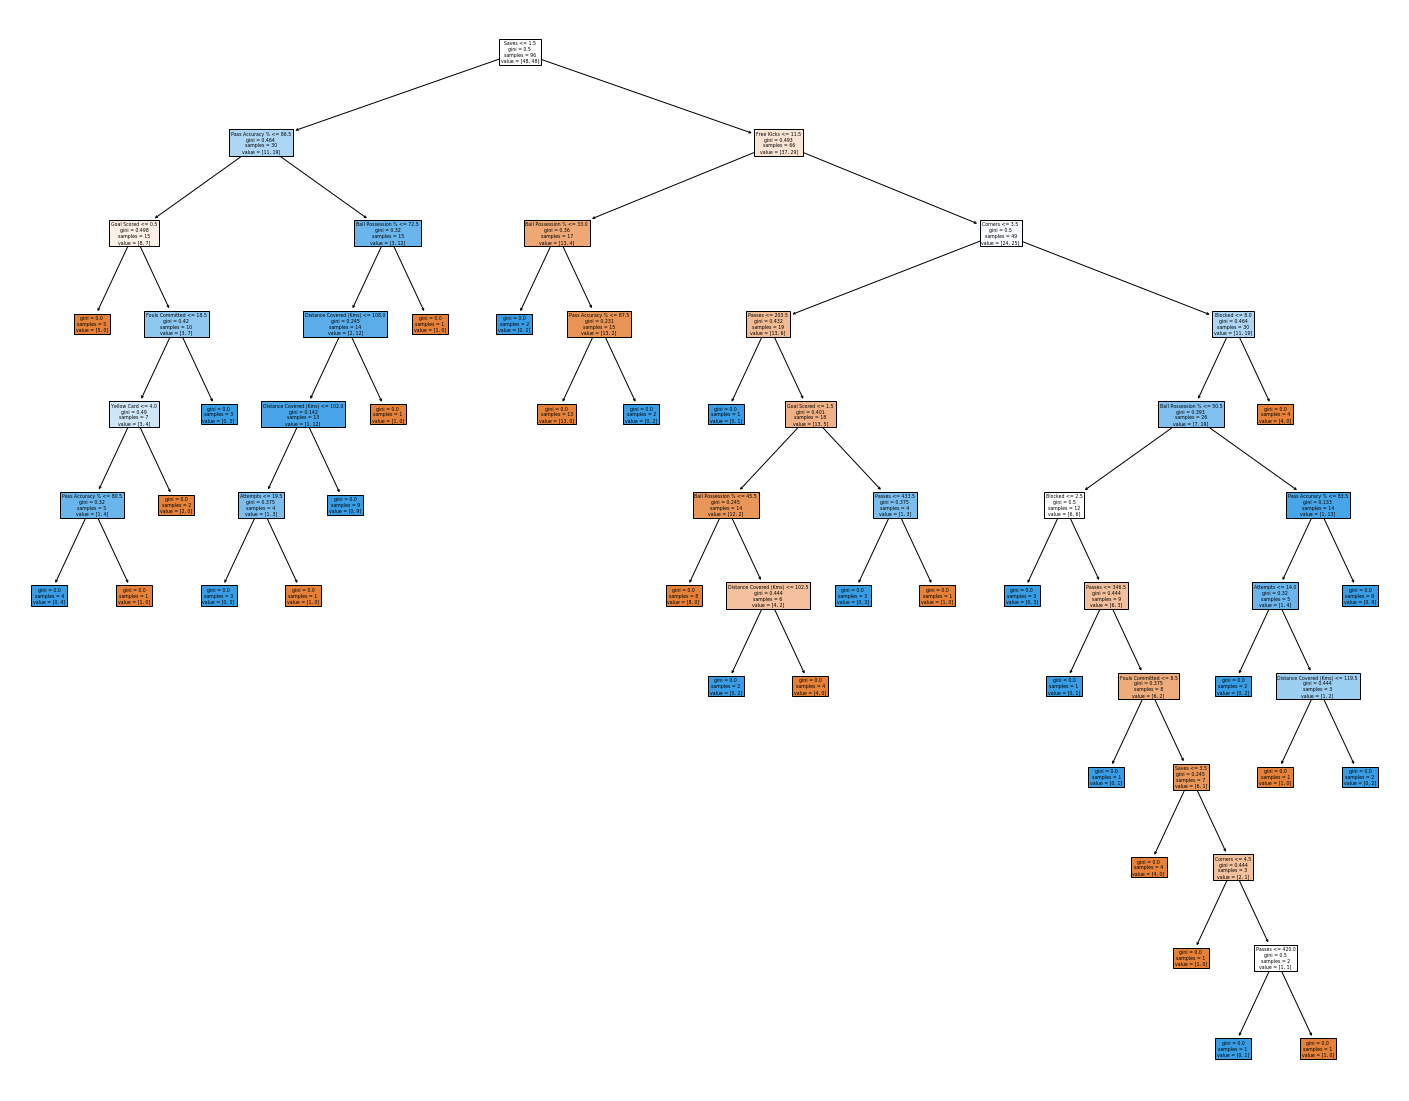

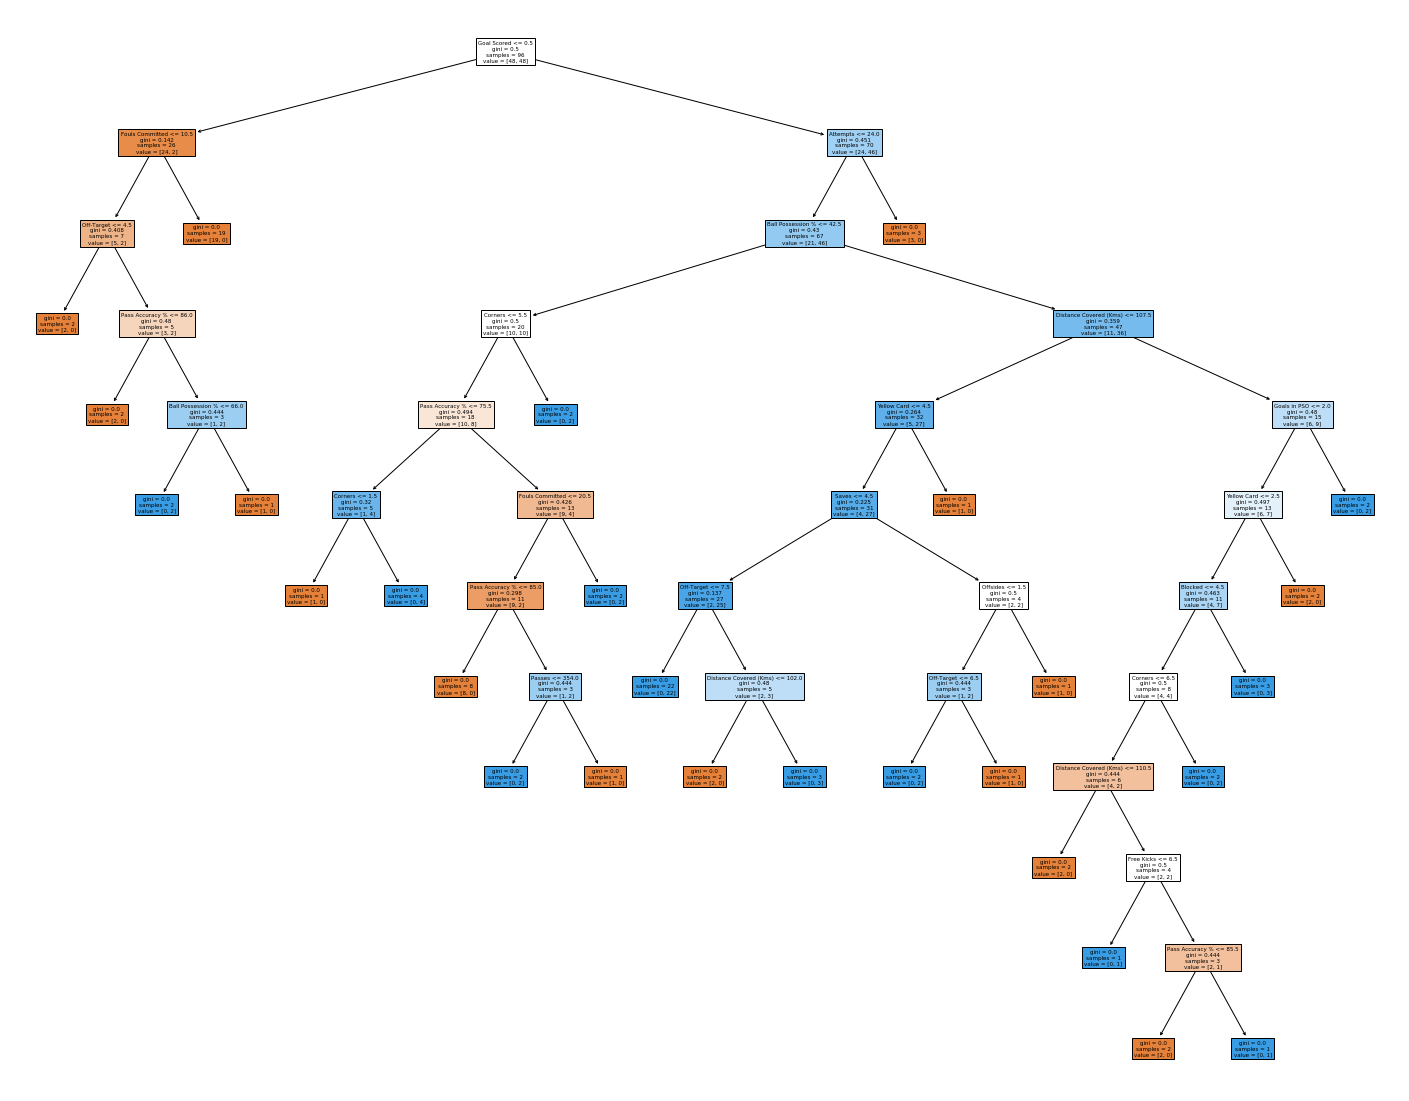

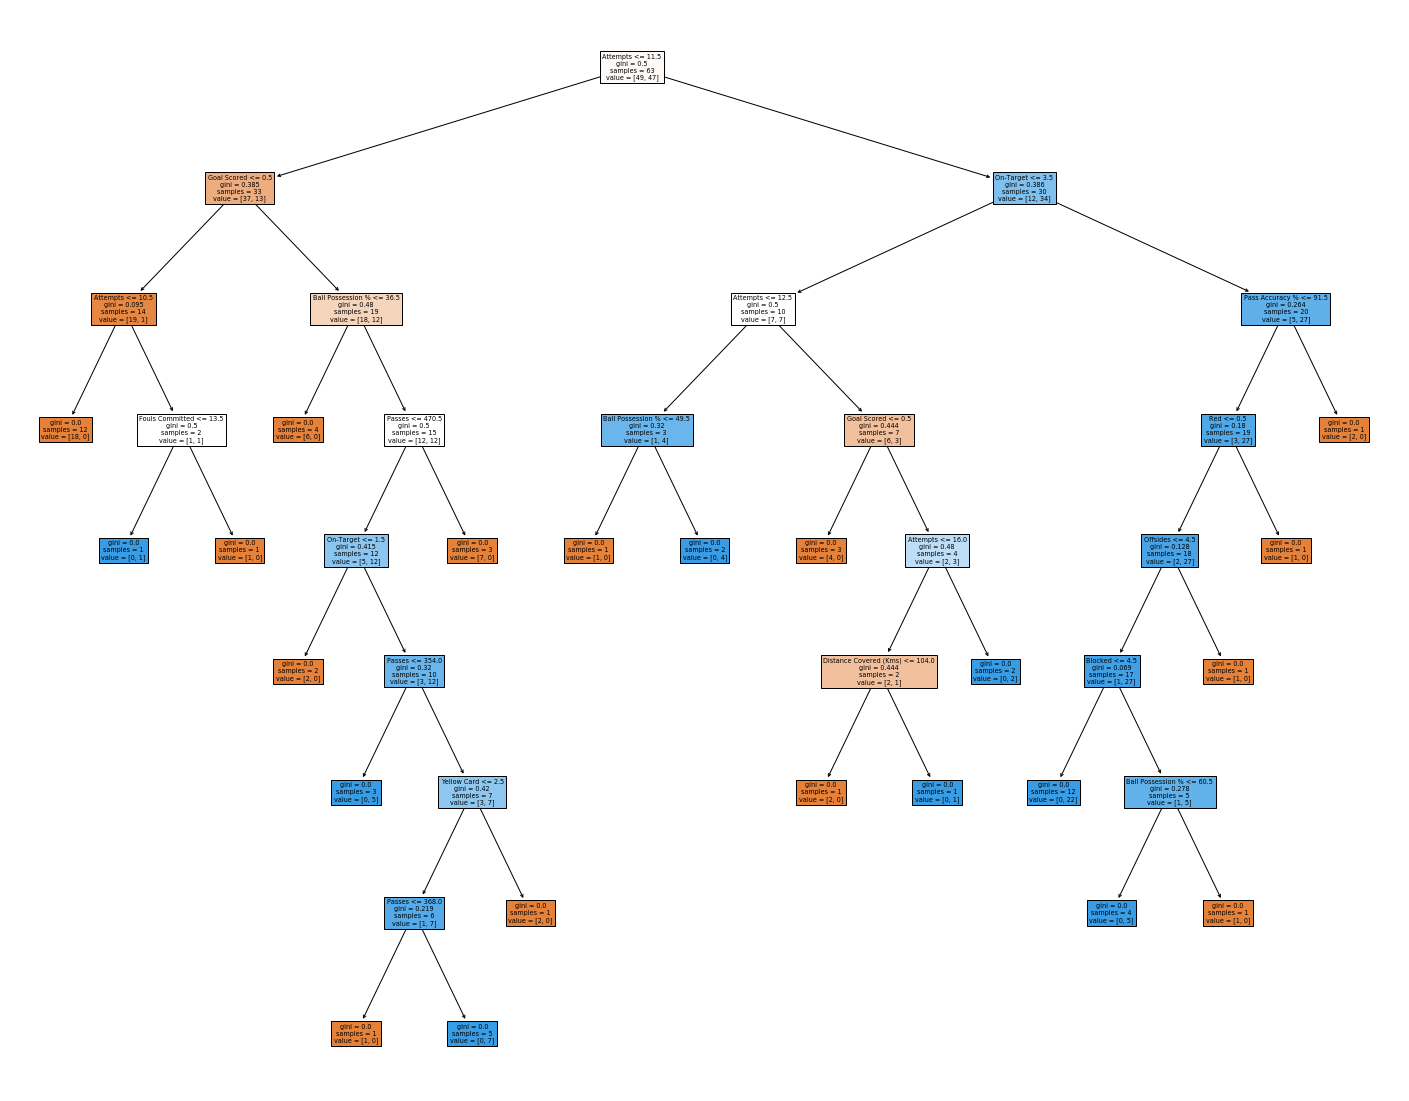

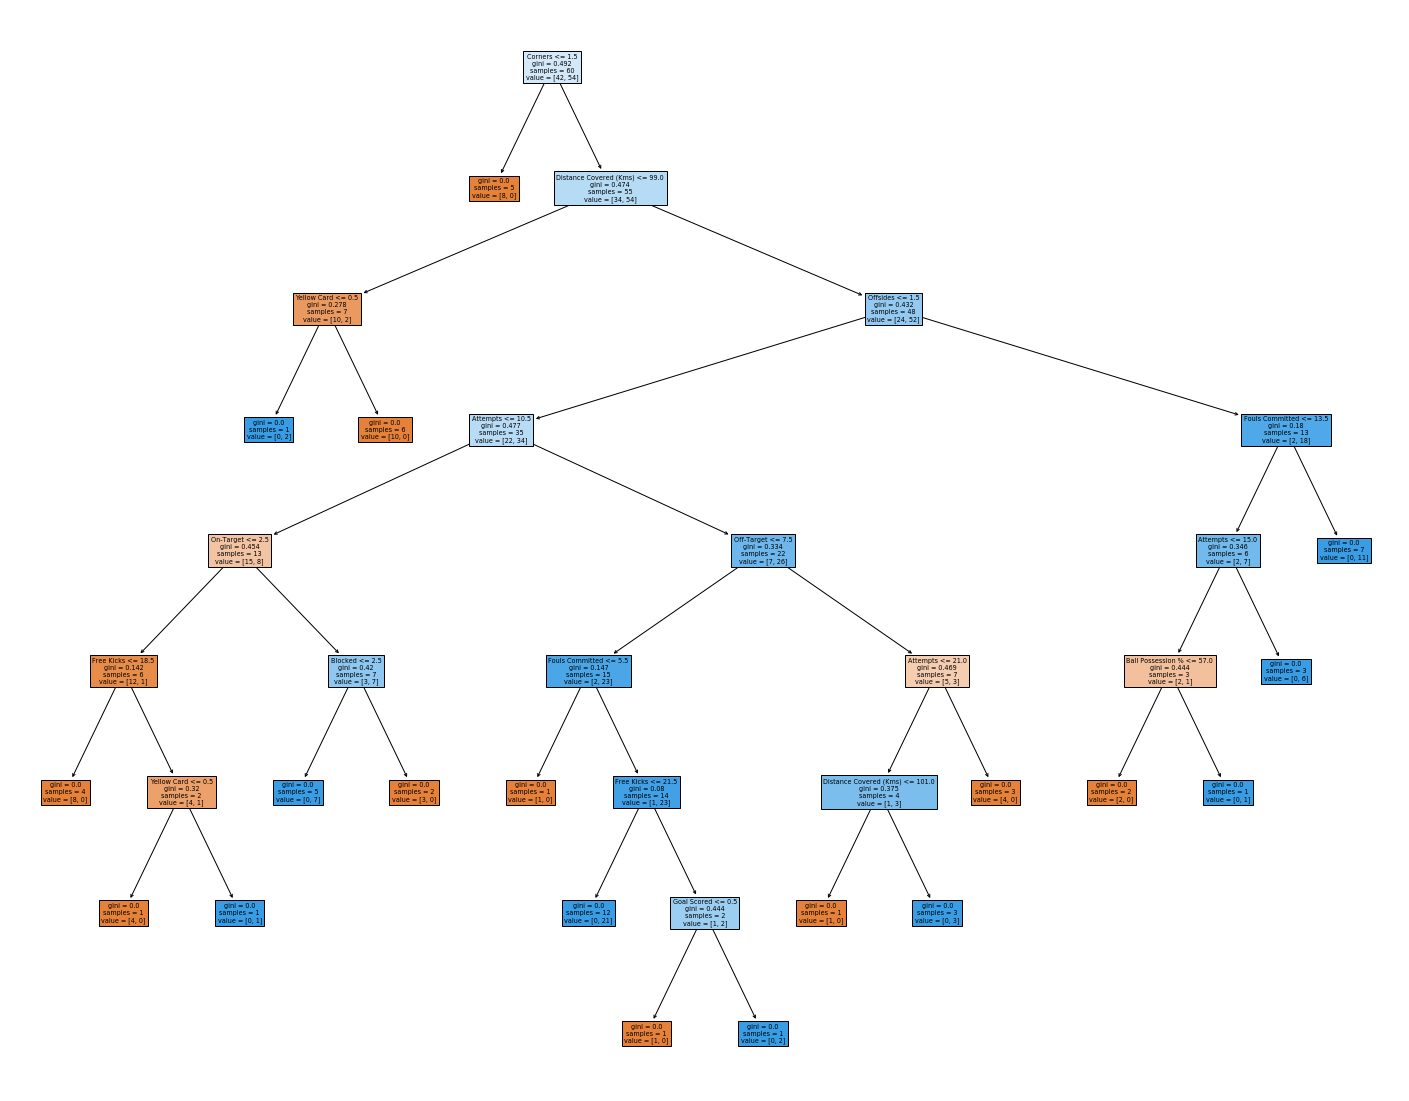

In [7]:
import random

# iscrtavanje nasumično odabranih stabala odluke iz prvog modela 
for i in range(2):
    n = random.randint(0, len(trained_model1.estimators_) - 1)
    estimator = trained_model1.estimators_[n]
    print(estimator)
    fig = plt.figure(figsize=(25,20))
    tree.plot_tree(estimator, feature_names=feature_names, filled=True)

# iscrtavanje nasumično odabranih stabala odluke iz drugo modela 
for i in range(2):
    n = random.randint(0, len(trained_model2.estimators_) - 1)
    estimator = trained_model2.estimators_[n]
    print(estimator)
    fig = plt.figure(figsize=(25,20))
    tree.plot_tree(estimator, feature_names=feature_names, filled=True)